In [8]:
%%bash

# wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
# wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2021-04-19 14:10:01--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

     0K .......... .......... .......... .........            100% 66.4M=0.001s

2021-04-19 14:10:02 (66.4 MB/s) - ‘dancing.jpg’ saved [40484/40484]



In [1]:
import sys
sys.path.append('..')

from rosettastone import maxact

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [111]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [113]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

#import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,   200] loss: 0.230
[1,   400] loss: 0.230
[1,   600] loss: 0.230
[1,   800] loss: 0.230
[1,  1000] loss: 0.229
[1,  1200] loss: 0.228
[1,  1400] loss: 0.222
[2,   200] loss: 0.202
[2,   400] loss: 0.196
[2,   600] loss: 0.191
[2,   800] loss: 0.186
[2,  1000] loss: 0.181
[2,  1200] loss: 0.176
[2,  1400] loss: 0.174
[3,   200] loss: 0.168
[3,   400] loss: 0.166
[3,   600] loss: 0.164
[3,   800] loss: 0.160
[3,  1000] loss: 0.157
[3,  1200] loss: 0.156
[3,  1400] loss: 0.156
[4,   200] loss: 0.150
[4,   400] loss: 0.148
[4,   600] loss: 0.148
[4,   800] loss: 0.147
[4,  1000] loss: 0.147
[4,  1200] loss: 0.146
[4,  1400] loss: 0.143
[5,   200] loss: 0.141
[5,   400] loss: 0.139
[5,   600] loss: 0.141
[5,   800] loss: 0.137
[5,  1000] loss: 0.138
[5,  1200] loss: 0.136
[5,  1400] loss: 0.135
[6,   200] loss: 0.134
[6,   400] loss: 0.132
[6,   600] loss: 0.133
[6,   800] loss: 0.129
[6,  1000] loss: 0.130
[6,  1200] loss: 0.130
[6,  1400] loss: 0.127
[7,   200] loss: 0.126
[7,   400] 

In [124]:
def freezer(module):
    for param in module.parameters():
        param.requires_grad = False

        
def weight_reset(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()
        

# DO I NEED THAT?
class IndifferenceLoss(nn.Module):

    def __init__(self, target):
        super().__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        return (F.mse_loss(input, self.target, reduction='none')
                             .mean(dim=(1, 2, 3)))
    
class DisentegelmentNet(nn.Module):

    def __init__(self, net, disentanglement_module_name, disentanglement_neuron_index,
                 indifference_module_name):
        super().__init__()
        self.net = copy.deepcopy(net)
        self.disentanglement_module_name = disentanglement_module_name
        self.disentanglement_neuron_index = disentanglement_neuron_index
        self.indifference_module_name = indifference_module_name
        self._build()
        freezer(self.net)

    def _build(self):
        pre_module = nn.Sequential()
        orig_disentanglement_module = nn.Sequential()
        orig_post_module = nn.Sequential()
        alt_disentanglement_module = nn.Sequential()
        alt_post_module = nn.Sequential()

        modules_iter = self.net.named_children()

        for name, layer in modules_iter:
            if name == self.disentanglement_module_name:
                break
            pre_module.add_module(name, copy.deepcopy(layer))
            freezer(pre_module)

        assert isinstance(layer, nn.Conv2d)

        
        orig_disentangled_layer_size = layer.out_channels
        alt_disentangled_layer_size = orig_disentangled_layer_size + 1
        
        with torch.no_grad():
            layer_copy = copy.deepcopy(layer)
            disentangled_layer = nn.Conv2d(layer.in_channels,
                                           alt_disentangled_layer_size,
                                           layer.kernel_size,
                                           layer.stride, layer.padding,
                                           layer.dilation, layer.groups,
                                           layer.bias is not None, layer.padding_mode)
            
            disentangled_layer.weight[:layer.out_channels, :, :, :] = layer_copy.weight
            disentangled_layer.bias[:layer.out_channels] = layer_copy.bias
            
            assert disentangled_layer.weight.shape[:2] == (alt_disentangled_layer_size, layer.in_channels)

            alt_disentanglement_module.add_module(name, disentangled_layer)
            alt_disentanglement_module.apply(weight_reset)
            
            orig_disentanglement_module.add_module(name, copy.deepcopy(layer))
        
        freezer(orig_disentanglement_module)


        is_first_post_parameterized_layer = True
        # TODO: take care of the immidate layer
        for name, layer in modules_iter:

            with torch.no_grad():
                layer_copy = copy.deepcopy(layer)
                post_disentangled_layer = layer_copy  # TODO: refactor me!
                if is_first_post_parameterized_layer:
                    if isinstance(layer, nn.Conv2d):
                        raise "foo"
                        is_first_post_parameterized_layer = False
                        post_disentangled_layer = nn.Conv2d(alt_disentangled_layer_size,
                                                            layer.out_channels,
                                                            layer.kernel_size,
                                                            layer.stride, layer.padding,
                                                            layer.dilation, layer.groups,
                                                            layer.bias is not None, layer.padding_mode)
                        
                        # todo copy weight, bias up and down
                    elif isinstance(layer, nn.Linear):
                        is_first_post_parameterized_layer = False
                        alt_post_in_features_size = (int(layer.in_features
                                                        / orig_disentangled_layer_size)
                                                     * alt_disentangled_layer_size)
                        
                        post_disentangled_layer = nn.Linear(alt_post_in_features_size,
                                                            layer.out_features,
                                                            layer.bias is not None)
                        
                        post_disentangled_layer.weight[:, :layer.in_features] = layer_copy.weight
                        post_disentangled_layer.bias[:layer.out_features] = layer_copy.bias

 
                alt_post_module.add_module(name, post_disentangled_layer)

                orig_post_module.add_module(name, copy.deepcopy(layer))

            if name == self.indifference_module_name:
                break

        freezer(orig_post_module)
        freezer(alt_post_module) # tricky, i need to catch the first going out weights, but it is good for now

        self.add_module('pre_module', pre_module)
        self.add_module('orig_disentanglement_module', orig_disentanglement_module)
        self.add_module('alt_disentanglement_module', alt_disentanglement_module)
        self.add_module('orig_post_module', orig_post_module)
        self.add_module('alt_post_module', alt_post_module)
        
        # self.add_module('indifference_loss', nn.MSELoss())

    def forward(self, x):
        x = self.pre_module(x)
        #print('PRE(x)', x.shape)

        x_orig = self.orig_disentanglement_module(x)
        #print('DISEN(x_orig)', x_orig.shape)
        #print('POST-orig-M', self.orig_post_module)
        x_orig = self.orig_post_module(x_orig)
        #print('POST(x_orig)', x_orig.shape)

        x_alt = self.alt_disentanglement_module(x)
        #print('DISEN(x_alt)', x_alt.shape)
        #print('POST-alt-M', self.alt_post_module)
        x_alt = self.alt_post_module(x_alt)
        #print('POST(x_alt)', x_alt.shape)

        indifference_loss = (torch.flatten(F.mse_loss(x_orig, x_alt, reduction='none'),1)
                             .mean())
        return indifference_loss #self.indifference_loss(x_orig, x_alt)

    def get_named_parameters(self):
        return [name
                for name, parameter in self.named_parameters()
                if parameter.requires_grad]

    

dnet = DisentegelmentNet(net.cpu(), 'conv2', 0, 'fc1')
dnet.to(device)

#dnet(images)

#print(dnet.get_named_parameters())

dnet(inputs)

tensor(1.9106, device='cuda:0', grad_fn=<MeanBackward0>)

In [139]:
optimizer = optim.SGD(dnet.parameters(), lr=0.001, momentum=0.9)

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)
#        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = torch.mean(dnet(inputs))
        #loss = dnet.indifference_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')



avgs = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, _ = data
        images = images.to(device)
        #labels = labels.to(device)

        outputs = dnet(images)
        bavg = outputs#torch.mean(outputs.data)
        total += 1#outputs.size(0)
        avgs += bavg

print('Avg of the network on the 10000 test images: %d loss' % (
    100 * avgs / total))

[1,   200] loss: 0.001
[1,   400] loss: 0.001
[1,   600] loss: 0.001
[1,   800] loss: 0.001
[1,  1000] loss: 0.001
[1,  1200] loss: 0.001
[1,  1400] loss: 0.001
[2,   200] loss: 0.001
[2,   400] loss: 0.001
[2,   600] loss: 0.001
[2,   800] loss: 0.001
[2,  1000] loss: 0.001
[2,  1200] loss: 0.001
[2,  1400] loss: 0.001
[3,   200] loss: 0.001
[3,   400] loss: 0.001
[3,   600] loss: 0.001
[3,   800] loss: 0.001
[3,  1000] loss: 0.000
[3,  1200] loss: 0.000
[3,  1400] loss: 0.000
Finished Training
Avg of the network on the 10000 test images: 0 loss


In [140]:
dnet.orig_disentanglement_module.conv2.weight, dnet.alt_disentanglement_module.conv2.weight

(Parameter containing:
 tensor([[[[-1.2033e-01, -3.3177e-02, -2.6256e-02, -1.3070e-02, -9.3323e-02],
           [-1.2232e-01, -2.4162e-02,  4.9518e-02,  2.1521e-02,  3.3592e-02],
           [-1.1518e-01, -1.6427e-01,  2.9834e-02,  1.2340e-01,  9.4190e-02],
           [ 2.2975e-01,  5.0389e-02, -3.2847e-02,  1.0657e-02,  5.2357e-02],
           [ 2.8878e-01,  2.0377e-01,  1.3064e-01, -2.0724e-02, -4.1447e-02]],
 
          [[-7.1501e-02, -3.7678e-02, -1.4254e-01, -7.5958e-02, -4.9511e-02],
           [-6.0703e-02, -8.2530e-02, -5.5172e-02, -5.7942e-02, -8.4604e-02],
           [-2.0422e-02, -4.9547e-02, -1.5699e-01, -8.8862e-02, -1.1016e-01],
           [ 5.8847e-02, -1.3714e-02, -1.6546e-03, -1.1863e-03, -1.2100e-01],
           [ 1.1103e-01,  9.3356e-02,  1.0908e-01,  5.5640e-02,  1.1026e-01]],
 
          [[ 8.2412e-02,  4.7240e-02,  4.3472e-02,  1.0224e-01,  7.4975e-02],
           [ 4.5360e-02,  5.8386e-02,  5.0779e-02,  2.6790e-02,  5.8347e-02],
           [-8.0053e-02,  7.7145e-0

In [127]:
net.conv2.bias

Parameter containing:
tensor([ 0.1114,  0.1771, -0.1666,  0.2550,  0.0089, -0.1375, -0.0313, -0.0656,
         0.0346, -0.0080, -0.1393, -0.2285, -0.0377,  0.2861, -0.2065,  0.1243],
       requires_grad=True)

In [128]:
dnet.orig_disentanglement_module.conv2.bias

Parameter containing:
tensor([ 0.1114,  0.1771, -0.1666,  0.2550,  0.0089, -0.1375, -0.0313, -0.0656,
         0.0346, -0.0080, -0.1393, -0.2285, -0.0377,  0.2861, -0.2065,  0.1243],
       device='cuda:0')

In [129]:
dnet.alt_disentanglement_module.conv2.bias

Parameter containing:
tensor([ 0.0764, -0.0032, -0.0845,  0.1341, -0.0765, -0.0849,  0.0413, -0.0920,
         0.0023, -0.0833, -0.0653, -0.0192, -0.1069,  0.2626,  0.0159, -0.0617,
        -0.0519], device='cuda:0', requires_grad=True)

In [ ]:
"""
i = 0  # increment every time we see a conv
for layer in net.children():
    print(layer)
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    
    elif isinstance(layer, nn.F.mse_loss):
        name = 'i_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    elif isinstance(layer, nn.Linear):
        name = 'linear' # TODO
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    if name == 'conv_2':
        state = 'in'
    if name == 'linear':
        state = 'post'

        
    if state == 'pre':
        pre_module.add_module(name, layer)
    
        
    if is_alt_branch:
        alt_layer = copy.deepcopy(layer)
        alt_branch.add_module(f'alt_{name}',  alt_layer)

        
last_layer = list(model.children())[-1]
alt_branch.add_module('indifference_loss', IndifferenceLoss(last_layer))
print(alt_branch)

    
    
"""
"""
    if name in content_layers:
        # add content loss:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        # add style loss:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

# now we trim off the layers after the last content and style losses
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break

model = model[:(i + 1)]

return model, style_losses, content_losses
""";

In [58]:
from torchviz import make_dot

!pip install torchviz
#make_dot(net(x), params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="png")


NameError: name 'x' is not defined

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


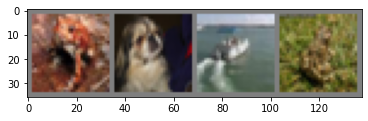

 frog   dog  ship  frog


In [107]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

[1,  2000] loss: 2.195
[1,  4000] loss: 1.901
[1,  6000] loss: 1.736
[1,  8000] loss: 1.602
[1, 10000] loss: 1.528
[1, 12000] loss: 1.439
[2,  2000] loss: 1.381
[2,  4000] loss: 1.354
[2,  6000] loss: 1.310
[2,  8000] loss: 1.285
[2, 10000] loss: 1.272
[2, 12000] loss: 1.237
Finished Training


In [26]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

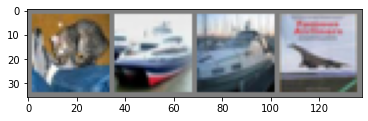

GroundTruth:    cat  ship  ship plane


In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

In [29]:
images = images.to(device)

outputs = net(images)

In [30]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog   car   car plane


Accuracy of the network on the 10000 test images: 55 %


In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 79 %
Accuracy of  bird : 34 %
Accuracy of   cat : 38 %
Accuracy of  deer : 35 %
Accuracy of   dog : 37 %
Accuracy of  frog : 83 %
Accuracy of horse : 67 %
Accuracy of  ship : 64 %
Accuracy of truck : 59 %


In [21]:
list(net.named_modules())

[('',
  Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )),
 ('conv1', Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))),
 ('pool',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('conv2', Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))),
 ('fc1', Linear(in_features=400, out_features=120, bias=True)),
 ('fc2', Linear(in_features=120, out_features=84, bias=True)),
 ('fc3', Linear(in_features=84, out_features=10, bias=True))]

In [23]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           num_workers=2)

# acts = maxact.harvest_activations(net, trainloader, module_names={'conv2'})

In [82]:
# harvast activations
# fix network parameters
# reinitialize new parameters

# iterate over the data


import copy

net2 = copy.deepcopy(net)
net2 = net2.to(device)
net2.conv1.reset_parameters()



with torch.no_grad():
    q =  {name: param.clone() for name, param in net.named_parameters()
        if name.startswith('conv1')}

 
    qq =  {name: param for name, param in net2.named_parameters()
        if name.startswith('conv1')}

    qq['conv1.weight'][1:, :, :] = q['conv1.weight'][1:, :, :]
    qq['conv1.bias'][1:] = q['conv1.bias'][1:]

    

activations, handles = maxact.hook_activations(net, modules)


#for handle in handels.values():
#        handle.remove()

In [89]:
criterion_indifference = nn.MSELoss()
optimizer_indifference = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [88]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.no_grad():
            net(inputs)
            
        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

tensor([[[ 0.0463,  0.0451, -0.0311,  0.2435,  0.3322],
         [ 0.0407,  0.0334,  0.0069, -0.0084,  0.2472],
         [ 0.0956,  0.1986,  0.0749, -0.1971,  0.0481],
         [-0.0274,  0.2611,  0.0792, -0.1645,  0.0088],
         [ 0.0191,  0.1665,  0.2452,  0.0411, -0.1945]],

        [[-0.0864, -0.1903, -0.1975, -0.2065,  0.0258],
         [ 0.1262, -0.0953, -0.3267, -0.3978, -0.0714],
         [ 0.0604,  0.1160, -0.2142, -0.4526, -0.2006],
         [ 0.0352,  0.0337,  0.0762, -0.4008, -0.1905],
         [-0.0725,  0.1961,  0.0973, -0.2468, -0.1441]],

        [[ 0.0576,  0.0617, -0.1746, -0.1564, -0.0106],
         [ 0.2046,  0.2478, -0.1537, -0.2497, -0.0619],
         [ 0.2405,  0.3903, -0.1493, -0.3667, -0.1625],
         [ 0.2909,  0.4164,  0.0955, -0.3131, -0.2681],
         [ 0.1754,  0.2619,  0.2468,  0.0419, -0.1610]]], device='cuda:0',
       grad_fn=<SelectBackward>)